<a href="https://colab.research.google.com/github/ksadowski13/gnn-workshop/blob/main/gcn_citeseer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
!pip install --quiet dgl dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install --quiet umap-learn

In [ ]:
from typing import Callable, Tuple

import dgl
import dgl.nn.pytorch as dglnn
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from umap import UMAP

# Dataset

In [ ]:
dataset = dgl.data.CiteseerGraphDataset()

In [ ]:
# Get graph from dataset
# https://docs.dgl.ai/tutorials/blitz/1_introduction.html
g = None  # ...

# Check
assert isinstance(g, dgl.DGLGraph)

In [ ]:
# Message passing creates new node embeddings by aggregating information from
# neighborhood. To make sure that node preserves information about itself 
# transform graph to have self-loops (tip: make sure that there will be only 1 
# self-loop per node).
# https://docs.dgl.ai/api/python/dgl.DGLGraph.html#transforming-graph
g = None  # ...

# Check if adding self-loops is done properly.
# (tip: get number of edges in the graph)
# https://docs.dgl.ai/api/python/dgl.DGLGraph.html#querying-graph-structure
assert None == 12431  # ...

In [ ]:
def visualize_graph(
    g: dgl.DGLGraph,
    node_embeddings: torch.Tensor,
    show_self_loop: bool = True,
) -> None:
    positions = UMAP(random_state=13).fit_transform(node_embeddings)
    positions = {nid: (pos[0], pos[1]) for nid, pos in enumerate(positions)}

    colors = {
        0: '#0077bb',
        1: '#33bbee',
        2: '#009988',
        3: '#ee7733',
        4: '#cc3311',
        5: '#ee3377',
    }

    node_colors = [colors[label.item()] for label in g.ndata['label']]

    plt.figure(figsize=(15, 15))
    nx.draw_networkx(
        dgl.to_networkx(g if show_self_loop else g.remove_self_loop()),
        pos=positions,
        arrows=False,
        with_labels=False,
        node_size=30,
        node_color=node_colors,
        width=0.1,
    )

In [ ]:
visualize_graph(g, g.ndata['feat'])

# Model
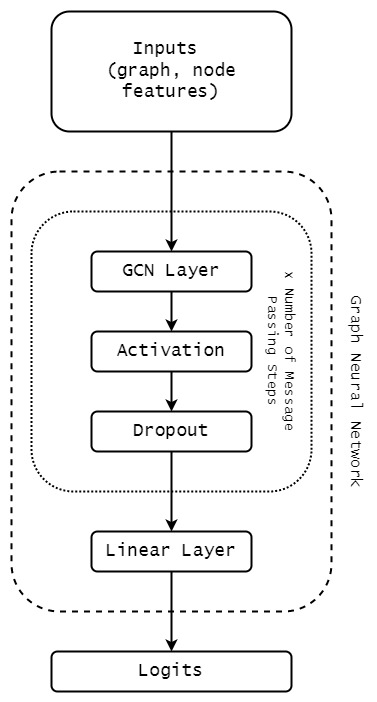

In [ ]:
class GCN(nn.Module):
    def __init__(
        self,
        in_feats: int,
        hidden_feats: int,
        out_feats: int,
        num_convs: int,
        activation: Callable[[torch.Tensor], torch.Tensor] = None,
        dropout: float = 0,
    ):
        super().__init__()
        self.activation = activation

        # Add dropout layer from torch.nn module.
        # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
        self.dropout = None  # ...

        self.layers = nn.ModuleList()

        # Add first GraphConv layer to the model with proper GCN parameters.
        # https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GraphConv.html
        # Take into account the input size and the hidden layer size.
        self.layers.append(None)  # ...

        for _ in range(num_convs - 1):
            # Add hidden GraphConv layers to the model with proper GCN parameters.
            # https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GraphConv.html
            # Take into account the hidden layer size.
            self.layers.append(None)  # ...

        # Add last prediction Linear layer.
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # Take into account the hidden layer size and the output size.
        self.layers.append(None)  # ...

    def forward(
        self,
        g: dgl.DGLGraph,
        inputs: torch.Tensor,
        prediction: bool = True,
    ) -> torch.Tensor:
        x = inputs

        for layer in self.layers:
            # Create model forward pass.
            if isinstance(layer, None):  #...
                # I. Forward pass through Graph Convolutions blocks.
                # 1. Graph Convolution
                x = None  # ...
                # 2. Activation
                x = None  # ...
                # 3. Dropout
                x = None  # ...
            else:
                # II. Forward pass through last prediction layer.
                if prediction:
                    x = None  # ...

        return x

# Training Utilities

In [ ]:
class CallBack:
    def __init__(
        self,
        patience,
        best_model_path: str = 'best_model.pt',
    ):
        self.patience = patience
        self.best_model_path = best_model_path

        self.train_losses = []
        self.train_accuracies = []
        self.valid_losses = []
        self.valid_accuracies = []

        self.counter = 0
        self.best_valid_loss = None

    @property
    def early_stopping(self) -> bool:
        return self.counter >= self.patience

    def checkpoint(
        self,
        train_loss: float,
        train_accuracy: float,
        valid_loss: float,
        valid_accuracy: float,
        model: nn.Module,
    ) -> None:
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_accuracy)
        self.valid_losses.append(valid_loss)
        self.valid_accuracies.append(valid_accuracy)

        if self.best_valid_loss is None or valid_loss < self.best_valid_loss:
            self.counter = 0
            self.best_valid_loss = valid_loss

            torch.save(model.state_dict(), self.best_model_path)
        else:
            self.counter += 1

    def plot_metrics(self):
        _, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 7.5))

        ax_1.set_title('loss')
        ax_1.set_xlabel('epoch')
        ax_1.plot(self.train_losses, label='train', color='#bb5566')
        ax_1.plot(self.valid_losses, label='validation', color='#004488')
        ax_1.legend()

        ax_2.set_title('accuracy')
        ax_2.set_xlabel('epoch')
        ax_2.plot(self.train_accuracies, label='train', color='#bb5566')
        ax_2.plot(self.valid_accuracies, label='validation', color='#004488')
        ax_2.legend()

        plt.tight_layout()        

    def load_best_model_parameters(self, model: nn.Module) -> None:
        model.load_state_dict(torch.load(self.best_model_path))

In [ ]:
def calculate_accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    _, indices = torch.max(logits, dim=-1)
    correct = torch.sum(indices == labels)
    accuracy = correct.item() / len(labels)

    return accuracy


def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    g: dgl.DGLGraph,
    mask: torch.Tensor,
) -> Tuple[float]:
    model.train()
    optimizer.zero_grad()

    # Prepare inputs (node features) and labels data by extracting it from graph object.
    # https://docs.dgl.ai/generated/dgl.DGLGraph.ndata
    # https://docs.dgl.ai/guide/training-node.html#guide-training-node-classification

    inputs = None # ...
    labels = None # ...

    logits = model(g, inputs)[mask]

    loss = loss_function(logits, labels)

    loss.backward()
    optimizer.step()

    accuracy = calculate_accuracy(logits, labels)

    return loss.item(), accuracy


def validate(
    model: nn.Module,
    loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    g: dgl.DGLGraph,
    mask: torch.Tensor,
) -> Tuple[float]:
    model.eval()

    # Prepare inputs (node features) and labels data by extracting it from graph object.
    # https://docs.dgl.ai/generated/dgl.DGLGraph.ndata
    # https://docs.dgl.ai/guide/training-node.html#guide-training-node-classification

    inputs = None # ...
    labels = None # ...

    with torch.inference_mode():
        logits = model(g, inputs)[mask]

        loss = loss_function(logits, labels)
        accuracy = calculate_accuracy(logits, labels)

    return loss.item(), accuracy

# Training

In [ ]:
torch.manual_seed(13)

# Setup the in_feats to size of the node feature vector.
# https://docs.dgl.ai/generated/dgl.data.CiteseerGraphDataset.html
# https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html#tensor-shapes
in_feats = None  # ...
hidden_feats = 256
# Setup the out_feats to expected size for the node classification (number of classes).
# https://docs.dgl.ai/generated/dgl.data.CiteseerGraphDataset.html
out_feats = None  # ...
num_convs = 2
activation = nn.ReLU()
dropout = 0.8

# Use defined variables to initialize model.
model = GCN(
    None,  # ...
    None,  # ...
    None,  # ...
    None,  # ...
    activation=None,  # ...
    dropout=None,  # ...
)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
callback = CallBack(15)

for epoch in range(500):
    train_loss, train_accuracy = train(
        model, optimizer, loss_function, g, g.ndata['train_mask'])
    valid_loss, valid_accuracy = validate(
        model, loss_function, g, g.ndata['val_mask'])

    callback.checkpoint(
        train_loss,
        train_accuracy, 
        valid_loss,
        valid_accuracy,
        model,
    )

    print(
        f'Epoch: {epoch + 1:03} Train Loss: {train_loss:.2f} '
        f'Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.2f} '
        f'Valid Accuracy: {valid_accuracy:.4f}'
    )

    if callback.early_stopping:
        break

callback.load_best_model_parameters(model)

test_loss, test_accuracy = validate(
    model, loss_function, g, g.ndata['test_mask'])

print(f'\nTest Loss {test_loss:.2f} Test Accuracy: {test_accuracy:.4f}')

callback.plot_metrics()

# Node Embeddings

## Learned Node Embeddings

In [ ]:
model.eval()

with torch.inference_mode():
    graph_conv_embedding = model(g, g.ndata['feat'], prediction=False)

In [ ]:
visualize_graph(g, graph_conv_embedding)

In [ ]:
visualize_graph(g, graph_conv_embedding, show_self_loop=False)

## Randomly Initialized Model Node Embeddings

In [ ]:
torch.manual_seed(13)

# Use previously defined variables to initialize model.
random_model = GCN(
    None,  # ...
    None,  # ...
    None,  # ...
    None,  # ...
    activation=None,  # ...
    dropout=None,  # ...
)

random_model.eval()

with torch.inference_mode():
    random_graph_conv_embedding = random_model(
        g, g.ndata['feat'], prediction=False)

In [ ]:
visualize_graph(g, random_graph_conv_embedding, show_self_loop=False)

## Message Passing Node Embeddings

In [ ]:
# Use GraphConv layer for message passing. Find out how to use this layer 
# without learned parameters.
# https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GraphConv.html
# (tip: you could set input and output size to 0)
message_passing = None  # ...

message_passing_embedding = g.ndata['feat']

for _ in range(2):
    message_passing_embedding = message_passing(g, message_passing_embedding)

In [ ]:
visualize_graph(g, message_passing_embedding, show_self_loop=False)